# Facies Classification from well logs

In this fourth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will implement Deep Feedforward Neural Network that can classify lithofacies given a suite of Well Logs. For this example we will use the openly available dataset from the [FORCE 2020 lithology prediction competition](https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition/tree/master/lithology_competition).

This notebooks is insipired by the work of [Olawale Ibrahim](https://github.com/olawaleibrahim), winner of the competition - his code can be accessed at this [link](https://github.com/olawaleibrahim/TRANSFORM-2021-tutorial).

More specifically, this notebook is organized as follows:

- a basic exploratory data analysis (EDA) is carried out to investigate the dataset and identify any required pre-processing (remember, Machine Learning is not just about training a model);
- data preparation and feature engineering;
- training using a gradient boosting algorithms called [Xgboost](https://xgboost.readthedocs.io/en/latest/) (very popular and exceptionally succesfull in ML competitions);
- training a DNN (mostly to learn how to do so, do not expect to obtain the best-in-class performance!)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary

from dataset import *
from model import *
from train import *
from utils import *

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

No GPU available!
Device: cpu


## Data retrieval

To begin with, we need to download the data that we will be using here. Head over to this [page](https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition/tree/master/lithology_competition/data) and click on the following files:

- train.csv
- leaderboard_test_features.csv.txt
- penalty_matrix.npy

You should see a `Download` button. Click it and place the 3 downloaded files into a folder called `data\welllogs`.

## Data loading

This dataset comes in 2 Comma-separated values (`*.csv`) files, one containing the training data and one containing the test data. If you plan to continue working on Machine Learning project, you may want to start familiarizing with this data format as most tabular data are generally stored in such a way.

Luckily, reading csv files has become very easy thanks to a library called [pandas](https://pandas.pydata.org). Feel free to learn more about it in your spare time. For the sake of this notebook, we can easily load these two datasets as follows.

We will however mostly work with the traindata here as it contains labels which we can use to assess the quality of our ML models. During the competition, teams were asked to deploy their models on the test (or blind) data and submit their scores.

In [3]:
traindata = pd.read_csv('../../data/welllogs/train.csv', sep=';')
testdata = pd.read_csv('../../data/welllogs/leaderboard_test_features.csv.txt', sep=';')

## Data Exploration and Visualization

Once we have loaded the data, the first thing we want to do is looking at some rows to get a first glance at what we will be working with, as well as the name of the different columns (features and target).

In [4]:
traindata.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [5]:
testdata.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN


In [6]:
traindata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [7]:
testdata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO'],
      dtype='object')

In [8]:
traindata.dtypes

WELL                                  object
DEPTH_MD                             float64
X_LOC                                float64
Y_LOC                                float64
Z_LOC                                float64
GROUP                                 object
FORMATION                             object
CALI                                 float64
RSHA                                 float64
RMED                                 float64
RDEP                                 float64
RHOB                                 float64
GR                                   float64
SGR                                  float64
NPHI                                 float64
PEF                                  float64
DTC                                  float64
SP                                   float64
BS                                   float64
ROP                                  float64
DTS                                  float64
DCAL                                 float64
DRHO      

**In-class question**: How many features are in the dataset?

We can immediately see that the test data is missing some columns

In [9]:
set(traindata.columns) - set(testdata.columns)

{'FORCE_2020_LITHOFACIES_CONFIDENCE', 'FORCE_2020_LITHOFACIES_LITHOLOGY'}

More specifically the last 2 columns. Not surprising as this is what we want to teach our NN to predict as well as a flag which contains a measure of confidence for the manual prediction.

**Question**: Can you think of a couple of different ways of using such an information when training a Machine Learning model?

### Geographical locations

The next thing we notice is that the second column contains the name of the wells available in this dataset. Let's try to understand how many wells we have access to.

In [10]:
trainwellnames = traindata['WELL'].unique()
print(trainwellnames)
print('Number of wells in train data:', len(trainwellnames))

['15/9-13' '15/9-15' '15/9-17' '16/1-2' '16/1-6 A' '16/10-1' '16/10-2'
 '16/10-3' '16/10-5' '16/11-1 ST3' '16/2-11 A' '16/2-16' '16/2-6' '16/4-1'
 '16/5-3' '16/7-4' '16/7-5' '16/8-1' '17/11-1' '25/11-15' '25/11-19 S'
 '25/11-5' '25/2-13 T4' '25/2-14' '25/2-7' '25/3-1' '25/4-5' '25/5-1'
 '25/5-4' '25/6-1' '25/6-2' '25/6-3' '25/7-2' '25/8-5 S' '25/8-7' '25/9-1'
 '26/4-1' '29/6-1' '30/3-3' '30/3-5 S' '30/6-5' '31/2-1' '31/2-19 S'
 '31/2-7' '31/2-8' '31/2-9' '31/3-1' '31/3-2' '31/3-3' '31/3-4' '31/4-10'
 '31/4-5' '31/5-4 S' '31/6-5' '31/6-8' '32/2-1' '33/5-2' '33/6-3 S'
 '33/9-1' '33/9-17' '34/10-19' '34/10-21' '34/10-33' '34/10-35' '34/11-1'
 '34/11-2 S' '34/12-1' '34/2-4' '34/3-1 A' '34/4-10 R' '34/5-1 A'
 '34/5-1 S' '34/7-13' '34/7-20' '34/7-21' '34/8-1' '34/8-3' '34/8-7 R'
 '35/11-1' '35/11-10' '35/11-11' '35/11-12' '35/11-13' '35/11-15 S'
 '35/11-6' '35/11-7' '35/12-1' '35/3-7 S' '35/4-1' '35/8-4' '35/8-6 S'
 '35/9-10 S' '35/9-2' '35/9-5' '35/9-6 S' '36/7-3' '7/1-1' '7/1-2 S']
Number 

In [11]:
testwellnames = testdata['WELL'].unique()
print(testwellnames)
print('Number of wells in test data:', len(testwellnames))

['15/9-14' '25/10-10' '25/11-24' '25/5-3' '29/3-1' '34/10-16 R' '34/3-3 A'
 '34/6-1 S' '35/6-2 S' '35/9-8']
Number of wells in test data: 10


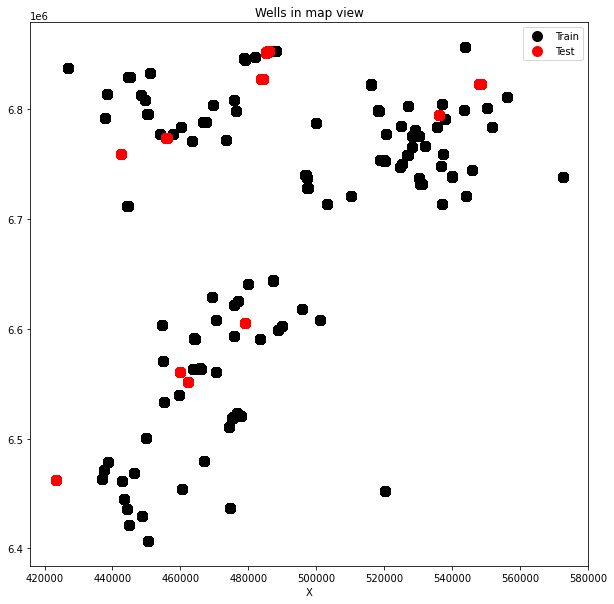

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(traindata['X_LOC'], traindata['Y_LOC'], '.k', ms=20, label='Train')
plt.plot(testdata['X_LOC'], testdata['Y_LOC'], '.r', ms=20, label='Test')
plt.xlabel('X')
plt.xlabel('X')
plt.title('Wells in map view')
plt.legend();

We can immediately observe how test wells are scattered all around, an indication that we may want to use all train wells in our ML model.

If you want to know more about any of these wells, the [Norwegian Petroleum Directorate](https://www.npd.no/en/) provides detailed information for any well in the North Sea. For example well 15/9-13 is an appraisal well in the Sleipner field as shown [here](https://factpages.npd.no/en/wellbore/PageView/Exploration/All/45)

### Categorical features

We also notice that some of the columns contain numbers whilst other contain strings. Let's investigate what information is provided and understand if this can be a useful feature to train a model

In [13]:
print("Formations:")
print(traindata['FORMATION'].value_counts())

Formations:
Utsira Fm.               172636
Kyrre Fm.                 94328
Lista Fm.                 71080
Heather Fm.               65041
Skade Fm.                 45983
                          ...  
Broom Fm.                   235
Intra Balder Fm. Sst.       177
Farsund Fm.                 171
Flekkefjord Fm.             118
Egersund Fm.                105
Name: FORMATION, Length: 69, dtype: int64


In [14]:
print("Groups:")
print(traindata['GROUP'].value_counts())

Groups:
HORDALAND GP.       293155
SHETLAND GP.        234028
VIKING GP.          131999
ROGALAND GP.        131944
DUNLIN GP.          119085
NORDLAND GP.        111490
CROMER KNOLL GP.     52320
BAAT GP.             35823
VESTLAND GP.         26116
HEGRE GP.            13913
ZECHSTEIN GP.        12238
BOKNFJORD GP.         3125
ROTLIEGENDES GP.      2792
TYNE GP.              1205
Name: GROUP, dtype: int64


### Numerical features (logs)

Let's move now to the actual well logs. First of all we want to try to understand the coverage across different wells and depths. We should expect that not all logs are acquired in every well and that different depth levels may be logged for different wells.

To start, we check how many wells have at certain log (at least in part)

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


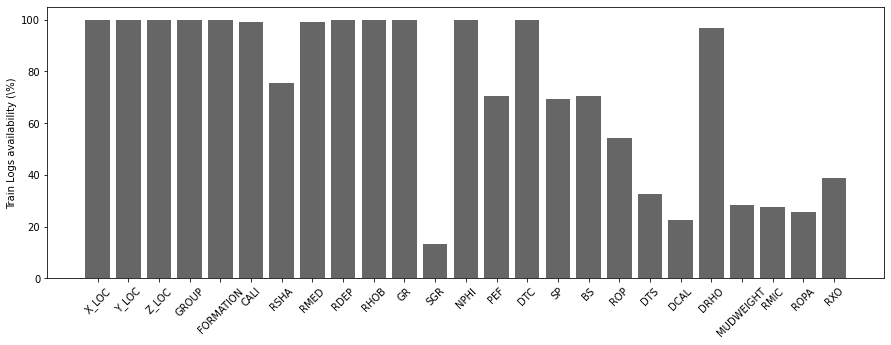

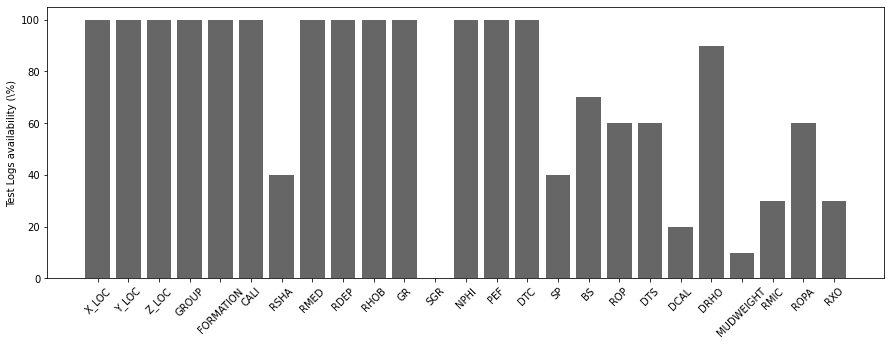

In [15]:
nlogs = 25 # Number of available numerical features (not all of them are real well logs)

# train
nwellstrain = traindata['WELL'].unique().size
occurences = np.zeros(nlogs)
for well in traindata['WELL'].unique():
    occurences += traindata[traindata['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), 
       height=(nwellstrain - occurences) / nwellstrain * 100.0, color='k', alpha=0.6)
ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Train Logs availability (\%)');

# test
nwellstest = testdata['WELL'].unique().size
occurences = np.zeros(nlogs)
for well in testdata['WELL'].unique():
    occurences += testdata[testdata['WELL'] == well].isna().all().astype(int).values[2:]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), 
       height=(nwellstest - occurences) / nwellstest * 100.0, color='k', alpha=0.6)
ax.set_xticklabels(testdata.columns[2:], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Test Logs availability (\%)');

We can immediately see how very few wells have Spectral Gamma Ray (SGR) logs. Similarly shear sonic log (DTS), Differential Caliper Log (DCAL), Mud Weight (MUDWEIGHT), Micro Resisitivity (RMIC) and Shallow Resistivity (RXO) are also available in very few wells.

We will later decide that is not worth trying to impute (fill) values for these logs and use them as feature of our ML model. We will get rid of them instead.

Similarly, we now look at the overall availability of each log in percentage.

In [16]:
traindata_logavailability = 100 - (traindata.isna().sum()/traindata.shape[0])[2:-2] * 100
testdata_logavailability = 100 - (testdata.isna().sum()/testdata.shape[0])[2:] * 100

In [17]:
testdata_logavailability

X_LOC         99.956867
Y_LOC         99.956867
Z_LOC         99.956867
GROUP        100.000000
FORMATION     94.828418
CALI          95.873116
RSHA          28.582603
RMED          99.570863
RDEP          99.956867
RHOB          87.601070
GR           100.000000
SGR            0.000000
NPHI          76.062609
PEF           82.978521
DTC           99.398330
SP            48.708932
BS            48.955302
ROP           49.943708
DTS           31.596801
DCAL           9.880397
DRHO          81.555130
MUDWEIGHT     14.818037
RMIC           8.272776
ROPA          40.786338
RXO           21.820947
dtype: float64

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


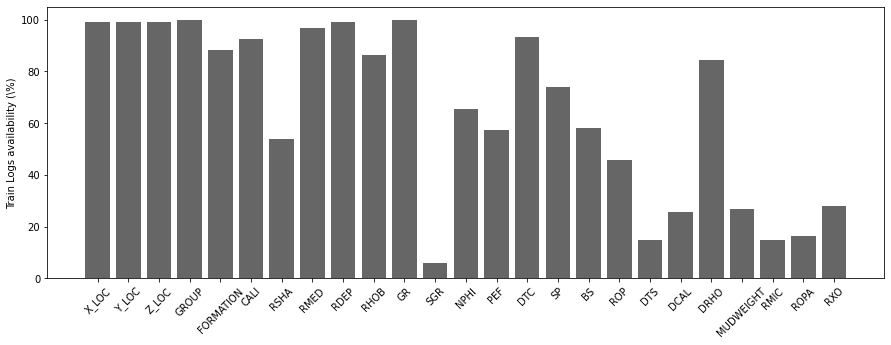

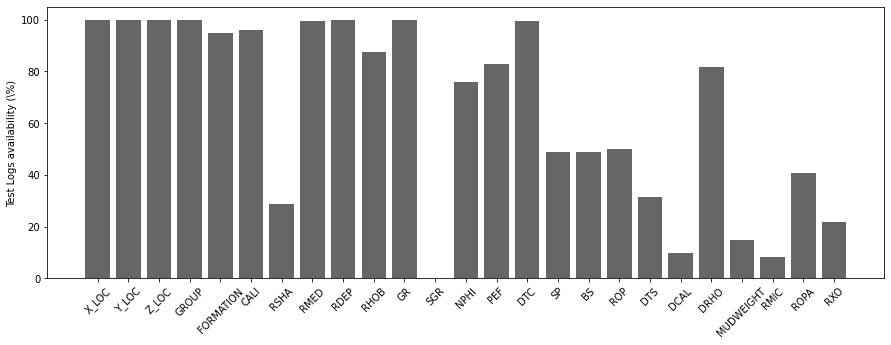

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), height=traindata_logavailability, color='k', alpha=0.6)
ax.set_xticklabels(traindata.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Train Logs availability (\%)');

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(nlogs), height=testdata_logavailability, color='k', alpha=0.6)
ax.set_xticklabels(testdata.columns[2:], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Test Logs availability (\%)');

### Labels

Let's now look at the labels we want to predict, the so-called *lithofacies*. First of all we give a name, a consecutive number, and a color to each label in the datasets.

In [19]:
nlithofacies = 12
lithofacies_names = {30000: 'Sandstone',
                     65030: 'SS/Shale',
                     65000: 'Shale',
                     80000: 'Dolomite',
                     74000: 'Tuff',
                     70000: 'Marl',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Coal', 
                     99000: 'Limestone',
                     90000: 'Anhydrite', 
                     93000: 'Basement'}
lithofacies_numbers = {30000: 0,
                       65030: 1,
                       65000: 2,
                       80000: 3,
                       74000: 4,
                       70000: 5,
                       70032: 6,
                       88000: 7,
                       86000: 8,
                       99000: 9,
                       90000: 10,
                       93000: 11}
lithofacies_colors =  {30000: 'y',
                       65030: '#96c136',
                       65000: 'g',
                       80000: '#5f5f5f',
                       74000: 'k',
                       70000: 'r',
                       70032: '#e5E5E5',
                       88000: 'c',
                       86000: 'b',
                       99000: 'm',
                       90000: '#fe9300',
                       93000: '#895347'}

trainlabels = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_names).value_counts()

In [20]:
print('Number of lithofacies in training set')
trainlabels

Number of lithofacies in training set


Shale        720803
Sandstone    168937
SS/Shale     150455
Marl          56320
Dolomite      33329
Limestone     15245
Chalk         10513
Halite         8213
Anhydrite      3820
Tuff           1688
Coal           1085
Basement        103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


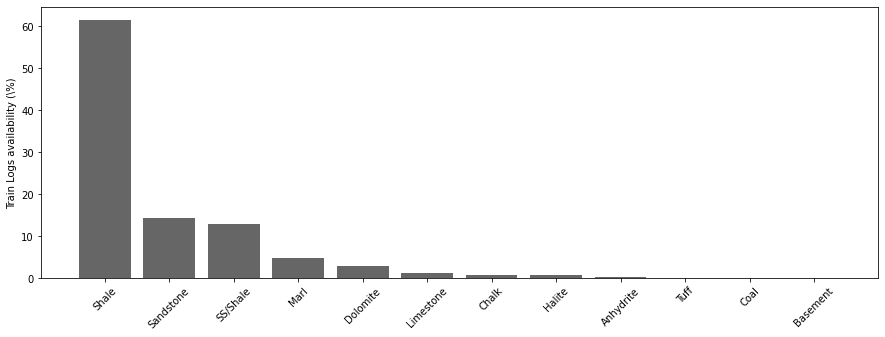

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(np.arange(len(trainlabels)), 100 * trainlabels.values / traindata.shape[0], color='k', alpha=0.6)
ax.set_xticklabels(trainlabels.keys(), rotation=45)
ax.set_xticks(np.arange(len(trainlabels.keys())))
ax.set_ylabel('Train Logs availability (\%)');

### Well logs

Finally, let's take a look at some of the wells in more details

In [22]:
traindata.select_dtypes(include=np.number)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,494.5280,437641.96875,6470972.5,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,494.6800,437641.96875,6470972.5,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,494.8320,437641.96875,6470972.5,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,494.9840,437641.96875,6470972.5,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,495.1360,437641.96875,6470972.5,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,3169.3124,NaN,NaN,NaN,8.423170,NaN,NaN,NaN,2.527984,77.654900,...,27.674368,NaN,NaN,-0.001763,NaN,NaN,26.673708,NaN,30000,2.0
1170507,3169.4644,NaN,NaN,NaN,8.379244,NaN,NaN,NaN,2.537613,75.363937,...,28.024338,NaN,NaN,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0
1170508,3169.6164,NaN,NaN,NaN,8.350248,NaN,NaN,NaN,2.491860,66.452843,...,28.091282,NaN,NaN,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0
1170509,3169.7684,NaN,NaN,NaN,8.313779,NaN,NaN,NaN,2.447539,55.784817,...,28.019775,NaN,NaN,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0


In order to make some pretty looking displays we will use a set of routines provided in the `Logs` class. In order to use such class we need to first save the well logs for each well into a LAS file. This is a very popular file format, and actually the one used by most commercial software for well log analysis. If you do some ML work in this domain you will most likely asked to output your results in a LAS file, so it is good to learn it since the beginning.

Luckily there exists a very useful Python library to read and write LAS files called `lasio`, which we are going to use here.

In [23]:
welldata = traindata[traindata['WELL'] == trainwellnames[1]]

las = lasio.LASFile()
numerical_columns = traindata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    las.add_curve(log, welldata[log].values)
las.write('../../data/welllogs/%s.las' %  trainwellnames[1].replace('/', '_'), version=1.2)

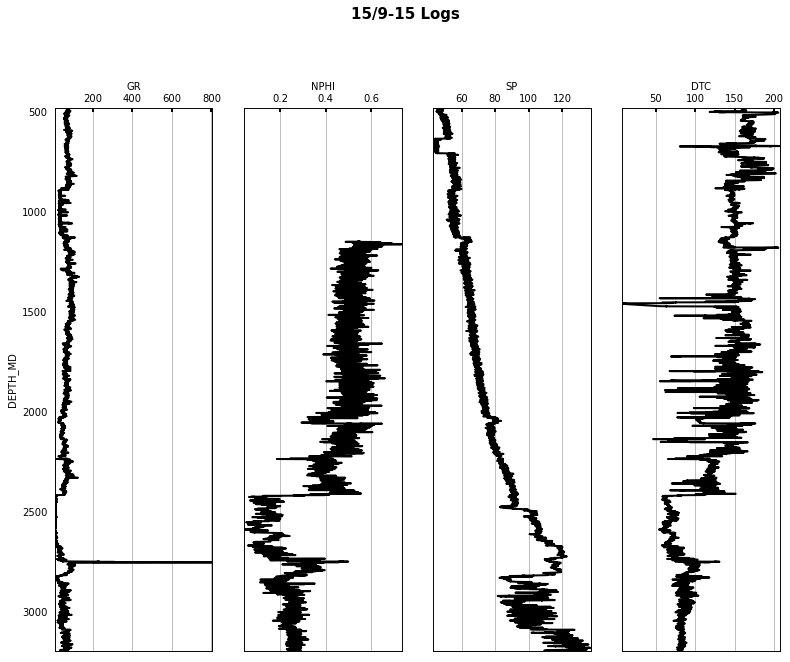

In [24]:
logs = Logs('../../data/welllogs/%s.las' %  trainwellnames[1].replace('/', '_'))

fig, axs = logs.visualize_logcurves(dict(GR=dict(logs=['GR'],
                                         colors=['k'],
                                         xlim=(np.nanmin(logs.logs['GR']),
                                                np.nanmax(logs.logs['GR']))),
                                         NPHI=dict(logs=['NPHI'],
                                                   colors=['k'],
                                                   xlim=(np.nanmin(logs.logs['NPHI']),
                                                         np.nanmax(logs.logs['NPHI']))),
                                         SP=dict(logs=['SP'],
                                                 colors=['k'],
                                                 xlim=(np.nanmin(logs.logs['SP']),
                                                       np.nanmax(logs.logs['SP']))),
                                         DTC=dict(logs=['DTC'],
                                                  colors=['k'],
                                                  xlim=(np.nanmin(logs.logs['DTC']),
                                                        np.nanmax(logs.logs['DTC'])))),
                         depth='DEPTH_MD', ylim=(480, 3200), figsize=(13, 10));
fig.suptitle('%s Logs' % trainwellnames[1], fontsize=15, fontweight='bold', y=1.02);

Finally we can also cross-plot our our numerical features to start to identify some patters and correlations

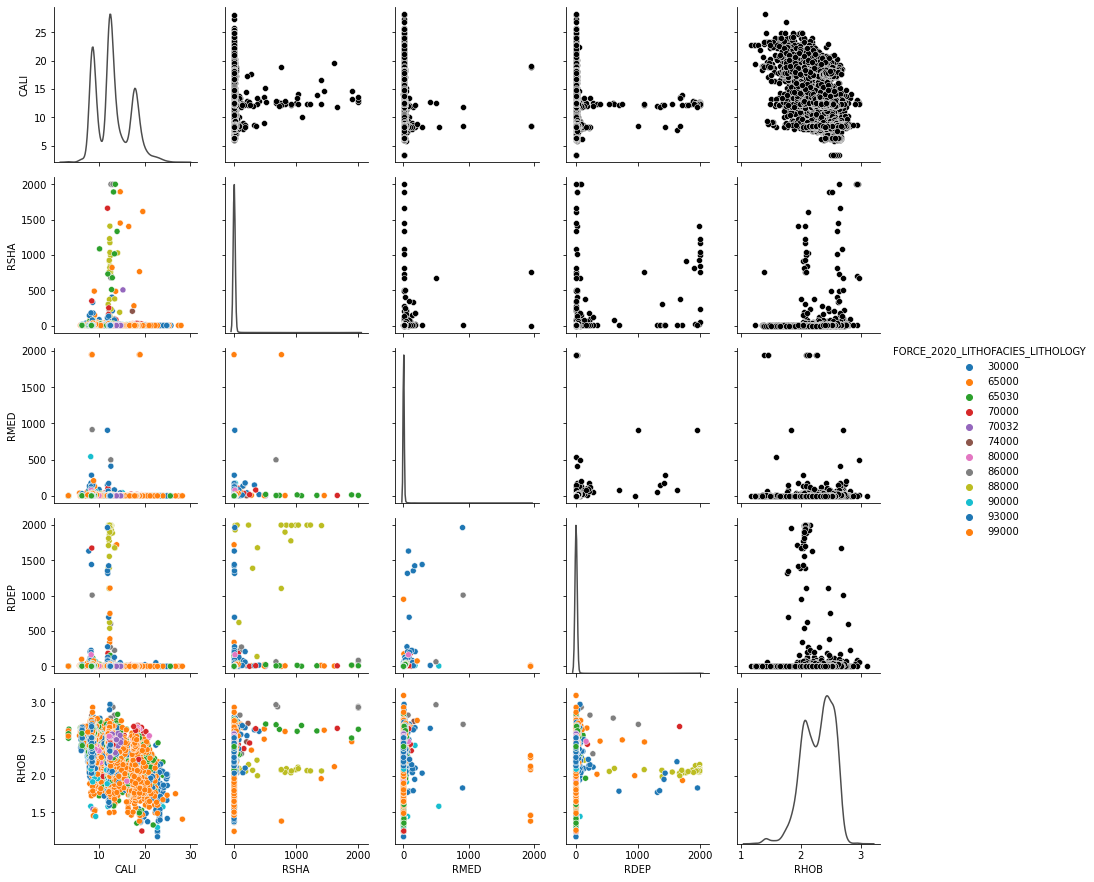

In [25]:
numerical_columns = traindata.select_dtypes(include=np.number).columns
g = sns.PairGrid(traindata.loc[::100, list(numerical_columns[4:9]) + list(numerical_columns[-2:-1])], 
                 hue="FORCE_2020_LITHOFACIES_LITHOLOGY",
                 diag_sharey=False, palette='tab10')
g.map_upper(sns.scatterplot, hue=None, color='k')
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, hue=None, color='.3')
g.add_legend();

**Exercise**: This plot is not very informative, other that clearly showing the presence of strong outliers in some of the logs. Try to remove/impute outliers and remake this plot. Do you see any better trends and clustering of classes.

## ML Modeling preparation

Based on the knowledge that we have acquired by looking at the data, we are now ready to start preparing the data to be fed to our ML models.

This process involves the following steps:

* Selecting well logs to be used as features
* Encoding categorical variables
* Imputing missing values
* Applying Data Augmentation strategies (optional)

### Selecting well logs

To begin with we drop those well logs that we decided are not worth using during our EDA

In [26]:
dropped_cols = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO']

traindata = traindata.drop(dropped_cols, axis=1)
testdata = testdata.drop(dropped_cols, axis=1)

traindata.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS',
       'ROP', 'DTS', 'DRHO', 'ROPA', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

### Encoding categorical variables

At this point we want to map categorical variables into numbers (we will use labels instead of one-hot encoding to keep the number of features to a reasonable number).

First of all we save a dictionary mapping well names to their numerical label that we can use later on when needed

In [27]:
trainwellcodes = dict(zip(traindata['WELL'].astype('category').cat.codes, traindata['WELL'] ) )
trainwellcodes1 = dict((v,k) for k,v in trainwellcodes.items()) # swap keys and values

Now we are ready to change the 3 categorical variables into numbers

In [28]:
traindata.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,29/6-1,4367.129001,444402.5625,6711929.0,-4323.834473,BAAT GP.,Ness Fm.,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,25/5-4,2271.328305,470379.0625,6608144.5,-2245.797852,ROGALAND GP.,Heimdal Fm.,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,34/10-35,2254.551000,463384.4375,6771048.5,-2231.373535,SHETLAND GP.,Vaale Fm.,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,31/4-5,1560.404796,503115.2500,6713756.5,-1535.076538,HORDALAND GP.,Utsira Fm.,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,34/10-21,2960.842403,454129.1250,6777267.5,-2931.367432,VIKING GP.,Draupne Fm.,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


In [29]:
traindata['GROUP'] = traindata['GROUP'].astype('category').cat.codes 
traindata['FORMATION'] = traindata['FORMATION'].astype('category').cat.codes
traindata['WELL'] = traindata['WELL'].astype('category').cat.codes

testdata['GROUP'] = testdata['GROUP'].astype('category').cat.codes 
testdata['FORMATION'] = testdata['FORMATION'].astype('category').cat.codes
testdata['WELL'] = testdata['WELL'].astype('category').cat.codes

traindata.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


**Question**: Could you define a better strategy to select the numbers for each element in a category instead of doing this randomly?

Finally we also want to map the lithofacies labels into consecutive numbers

In [30]:
traindata.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,65030,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,65000,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,65000,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,65000,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,65000,1.0


In [31]:
traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_numbers)
traindata.sample(n=5, random_state=5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,RDEP,...,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
489246,37,4367.129001,444402.5625,6711929.0,-4323.834473,0,41,9.289488,2.189590,2.059643,...,113.754364,92.285614,52.642662,NaN,NaN,NaN,-0.014605,NaN,1,1.0
357889,28,2271.328305,470379.0625,6608144.5,-2245.797852,7,24,11.907391,1.060567,0.829788,...,6.155957,101.428360,84.138863,12.250001,NaN,NaN,0.042459,NaN,2,1.0
798724,63,2254.551000,463384.4375,6771048.5,-2231.373535,9,68,20.404840,1.203076,1.420562,...,11.167521,107.851089,22.276651,NaN,NaN,NaN,0.129825,NaN,2,1.0
653894,51,1560.404796,503115.2500,6713756.5,-1535.076538,5,67,18.153017,0.683648,0.621936,...,NaN,149.761688,107.608055,NaN,NaN,NaN,0.017562,NaN,2,1.0
777890,61,2960.842403,454129.1250,6777267.5,-2931.367432,12,11,14.559240,1.525538,1.145223,...,10.739023,98.038651,32.000000,NaN,NaN,NaN,0.033609,NaN,2,1.0


In [32]:
print('Number of lithofacies in training set')
traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

Number of lithofacies in training set


2     720803
0     168937
1     150455
5      56320
3      33329
9      15245
6      10513
7       8213
10      3820
4       1688
8       1085
11       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

### Filling Missing Values

We have noticed during our EDA that missing values exist for almost all the logs. We need to handle them prior to feeding our data to a ML model. Whilst various more or less advanced strategies can be used (we already discussed above a possible way to handle them with an extra ML model)

In this case we can follow the simple strategy adopted by the winner of the competition, all missing values are filled with -9999. This can however be dangerous if you want to use NNs or do any sort of rescaling of your features. For this reason we decide to fill the missing values using values above and below.

In [33]:
# Fill missing values with -9999
#traindata = traindata.fillna(-9999)
#testdata = testdata.fillna(-9999)

# Impute missing values 
traindata = traindata.fillna(method='pad')
testdata = testdata.fillna(method='pad')

traindata = traindata.fillna(method='backfill')
testdata = testdata.fillna(method='backfill')

print('% Remaining missing values in train data:')
print(traindata.isna().sum()/traindata.shape[0] * 100)

print('% Remaining missing values in test data:')
print(testdata.isna().sum()/testdata.shape[0] * 100)

% Remaining missing values in train data:
WELL                                 0.0
DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
GROUP                                0.0
FORMATION                            0.0
CALI                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DTS                                  0.0
DRHO                                 0.0
ROPA                                 0.0
FORCE_2020_LITHOFACIES_LITHOLOGY     0.0
FORCE_2020_LITHOFACIES_CONFIDENCE    0.0
dtype: float64


**Exercise**: Do you think pad+backfill is a good strategy in the light of how the test data looks like? Propose other pre-processing strategies that do not involve training another ML model which could provide any improvemented in terms of model accuracy!

### Data augmentation

A key component of any ML project is represented by the so-called *Data Augmentation* (or *Feature Engineering*) step. This amounts to creating additional features by combining those currently available. As an example, you may think of creating derived logs (e.g., Porosity) based on physically recorded logs (e.g., Density).

The data augmentation technique shown below is taken from the code that the ISPL team from Politecnico of Milano developed for the 2016 SEG ML competition. Such technique is based on the assumption that *facies do not abrutly change from a given depth layer to the next one*, and so new features can be created by averaging each well log along sliding windows as well as computing their spatial gradients.

Link to GitHub repository: https://github.com/seg/2016-ml-contest/tree/master/ispl.

We initially decide not to use these additional features in our ML model. 

**Exercise**: Try to play with them and see if they are beneficial.

In [34]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

def add_suffix(elements, string):
    return [el + string for el in elements]

In [35]:
# Choose which features to augument 
aug_labels = list(traindata.columns)
aug_labels.remove('WELL')
aug_labels.remove('FORCE_2020_LITHOFACIES_LITHOLOGY')
aug_labels.remove('FORCE_2020_LITHOFACIES_CONFIDENCE')

aug_labels

['DEPTH_MD',
 'X_LOC',
 'Y_LOC',
 'Z_LOC',
 'GROUP',
 'FORMATION',
 'CALI',
 'RMED',
 'RDEP',
 'RHOB',
 'GR',
 'NPHI',
 'PEF',
 'DTC',
 'SP',
 'BS',
 'ROP',
 'DTS',
 'DRHO',
 'ROPA']

In [36]:
print(f'Shape of datasets before augmentation {traindata.loc[:, aug_labels].shape, testdata.loc[:, aug_labels].shape}')

aug_traindata = augment_features(traindata.loc[:, aug_labels].values, 
                                 traindata['WELL'], traindata['DEPTH_MD'])
aug_testdata = augment_features(testdata.loc[:, aug_labels].values, 
                                testdata['WELL'], testdata['DEPTH_MD'])

print(f'Shape of datasets after augmentation {aug_traindata.shape, aug_testdata.shape}')

Shape of datasets before augmentation ((1170511, 20), (136786, 20))
Shape of datasets after augmentation ((1170511, 80), (136786, 80))


In [37]:
aug_newlabels = add_suffix(aug_labels, '_AVE1') + add_suffix(aug_labels, '_AVE2') + \
                add_suffix(aug_labels, '_AVE3') + add_suffix(aug_labels, '_DIFF')

aug_traindata = pd.DataFrame(aug_traindata, columns=aug_newlabels)
aug_testdata = pd.DataFrame(aug_traindata, columns=aug_newlabels)

# combine original and augumented features
#traindata = pd.concat((traindata, aug_traindata), axis=1)
#testdata = pd.concat((testdata, aug_testdata), axis=1)

## ML modelling

We are finally ready to run our data through a ML model. First of all let's write a few functions to evaluate the model performance.

In [38]:
A = np.load('../../data/welllogs/penalty_matrix.npy')   # Penalty matrix used for scoring

In [39]:
def force_score(y_true, y_pred, A):
    """
    FORCE score
    """
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        (y_true[i], y_pred[i])
        S -= A[y_true[i], y_pred[i]]
    return S / y_true.shape[0]

In [40]:
def show_evaluation(pred, true):
    print(f'Force score is: {force_score(true.values, pred, A)}')
    print(f'Accuracy is: {accuracy_score(true, pred)}')
    print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

We also decide to take some wells out of the training data and use them for validation purposes

In [41]:
random.seed(15)
validnwells = 10
validwellnames = random.sample(list(trainwellnames), validnwells)
validwelllabels = [trainwellcodes1[wellname] for wellname in validwellnames]
validnwellcodes = dict((v,k) for k,v in zip(validwellnames, validwelllabels))
validnwellcodes1 = dict((v,k) for k,v in validnwellcodes.items()) # swap keys and values
validwellnames, validnwellcodes1

(['25/4-5',
  '15/9-15',
  '34/12-1',
  '35/9-6 S',
  '16/1-6 A',
  '25/11-19 S',
  '25/6-2',
  '15/9-17',
  '16/10-3',
  '35/3-7 S'],
 {'25/4-5': 26,
  '15/9-15': 1,
  '34/12-1': 66,
  '35/9-6 S': 94,
  '16/1-6 A': 4,
  '25/11-19 S': 20,
  '25/6-2': 30,
  '15/9-17': 2,
  '16/10-3': 7,
  '35/3-7 S': 87})

In [42]:
validdata = traindata[traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)
traindata = traindata[~traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)

In [43]:
# Ensure the training data contains all 12 facies... if not change seed and rerun!!
print('Number of lithofacies', len(traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()))

Number of lithofacies 12


Finally we remove the target column from the training data and store it in a separate DataFrame

In [44]:
trainlitho = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']
traindata = traindata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)
trainlitho

0          2
1          2
2          2
3          2
4          2
          ..
1055424    0
1055425    1
1055426    1
1055427    1
1055428    1
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 1055429, dtype: int64

In [45]:
validlitho = validdata['FORCE_2020_LITHOFACIES_LITHOLOGY']
validdata = validdata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)
validlitho

0         2
1         2
2         2
3         2
4         2
         ..
115077    0
115078    0
115079    0
115080    0
115081    0
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 115082, dtype: int64

### XGBClassifier

We will start using *XGBClassifier* who was used by most of the top scoring teams in the competition.

We are going to use *Stratified-KFold crossvalidation*. This is a special type of crossvalidation where the training data is split into two parts whilst ensuring that the percentage of
samples for each class is preserved.

In [46]:
split = 10
kf = StratifiedKFold(n_splits=split, shuffle=False)

In [47]:
# initializing the xgboost model
model = xgb.XGBClassifier(n_estimators=10, # he uses 100
                          max_depth=10, booster='gbtree',
                          objective='softprob', learning_rate=0.1, random_state=0,
                          subsample=0.9, colsample_bytree=0.9, 
                          tree_method='hist', #tree_method='gpu_hist',
                          use_label_encoder=False,
                          eval_metric='mlogloss', reg_lambda=1500, n_jobs=-1)

In [48]:
#implementing the CV Loop
train_pred = np.zeros((traindata.shape[0], nlithofacies))
valid_pred = np.zeros((validdata.shape[0], nlithofacies))


for ifold, (train_index, valid_index) in enumerate(kf.split(traindata, trainlitho)):
    X_train, X_valid = traindata.iloc[train_index], traindata.iloc[valid_index]
    Y_train, Y_valid = trainlitho.iloc[train_index], trainlitho.iloc[valid_index]
    
    #X_train = scaler.transform(X_train)
    #X_valid = scaler.transform(X_valid)
    
    model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_valid, Y_valid)], verbose=0)
    
    trainprediction = model.predict(X_train)
    validprediction = model.predict(X_valid)
    
    print(f'----------------------- FOLD {ifold} ---------------------')
    print('Training score....')
    show_evaluation(trainprediction, Y_train)
    print('Validation score....')
    show_evaluation(validprediction, Y_valid)
    
    # Stack models (ensemble prediction)
    train_pred += model.predict_proba(traindata)
    valid_pred += model.predict_proba(validdata)

----------------------- FOLD 0 ---------------------
Training score....
Force score is: -0.4714215705884706
Accuracy is: 0.8256001246465365
F1 is: 0.8439048250876354
Validation score....
Force score is: -2.614144235051117
Accuracy is: 0.19268923566697935
F1 is: 0.14801230959261827
----------------------- FOLD 1 ---------------------
Training score....
Force score is: -0.46578128849146105
Accuracy is: 0.8272940121235601
F1 is: 0.8439971668187015
Validation score....
Force score is: -0.780536132192566
Accuracy is: 0.6924286783585837
F1 is: 0.7223487190044608
----------------------- FOLD 2 ---------------------
Training score....
Force score is: -0.46357562907548905
Accuracy is: 0.8283520338230062
F1 is: 0.8453993427758302
Validation score....
Force score is: -0.9353675753010622
Accuracy is: 0.63665046473949
F1 is: 0.6535405726835232
----------------------- FOLD 3 ---------------------
Training score....
Force score is: -0.4549801239306612
Accuracy is: 0.8309049717545053
F1 is: 0.84822815

Finally we use the predicted probabilities averaged over the ensemble of models to produce our Maximum-A-Posterior (MAP) estimates

In [49]:
# Finding the probabilities average and converting the numpy array to a dataframe
train_pred = pd.DataFrame(train_pred / split)
valid_pred = pd.DataFrame(valid_pred / split)

In [50]:
# Extracting the index position with the highest probability as the lithology classp
train_pred = train_pred.idxmax(axis=1)
train_pred.index = trainlitho.index

valid_pred = valid_pred.idxmax(axis=1)
valid_pred.index = validlitho.index

Let's look now at some metrics to evaluate the quality of our model

In [51]:
show_evaluation(train_pred.reset_index(drop=True), trainlitho)

Force score is: -0.481462514295135
Accuracy is: 0.820999801976258
F1 is: 0.8408508002518512


In [52]:
show_evaluation(valid_pred.reset_index(drop=True), validlitho)

Force score is: -0.6615293877409152
Accuracy is: 0.7486835473836048
F1 is: 0.805793175042696


In [53]:
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = validlitho
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'] = valid_pred

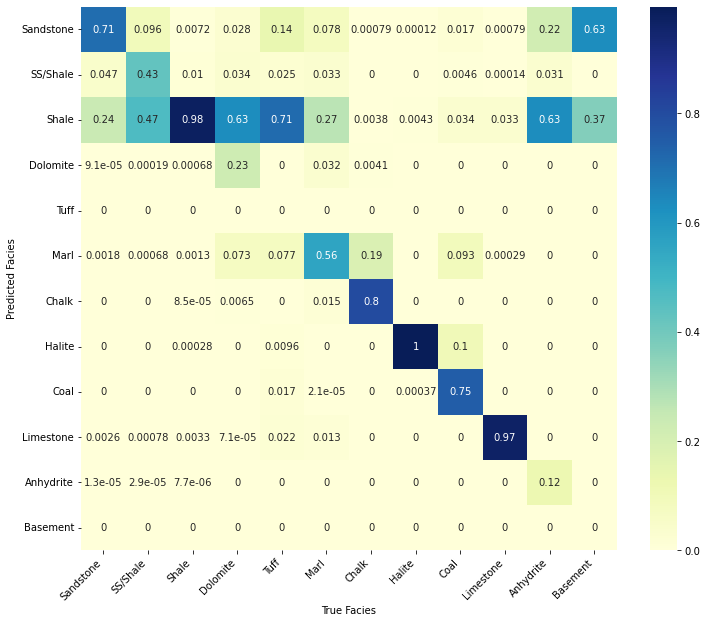

In [54]:
confusion_matrix_facies(train_pred.reset_index(drop=True).values, 
                        trainlitho.values, facies_labels=list(lithofacies_names.values()));

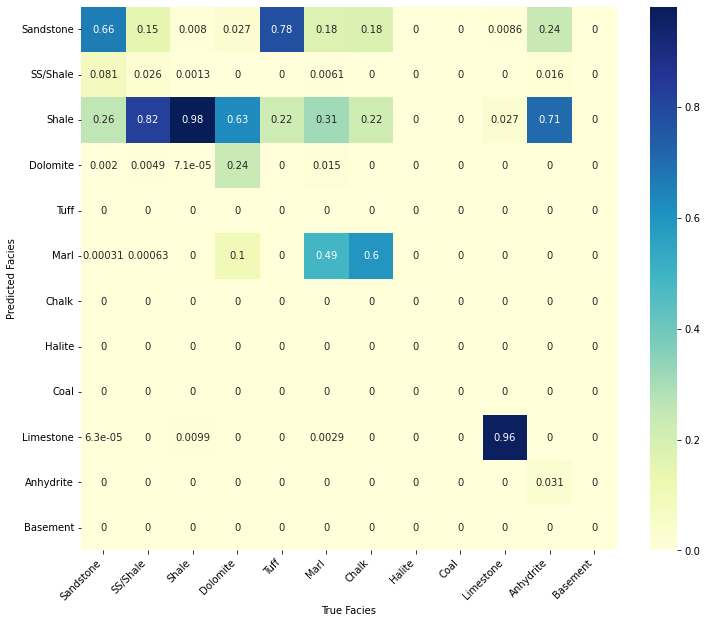

In [55]:
confusion_matrix_facies(valid_pred.reset_index(drop=True).values, 
                        validlitho.values, facies_labels=list(lithofacies_names.values()));

We may find some insights into why some classes are predicted more or less accurately than others by looking at some detailed crossplots

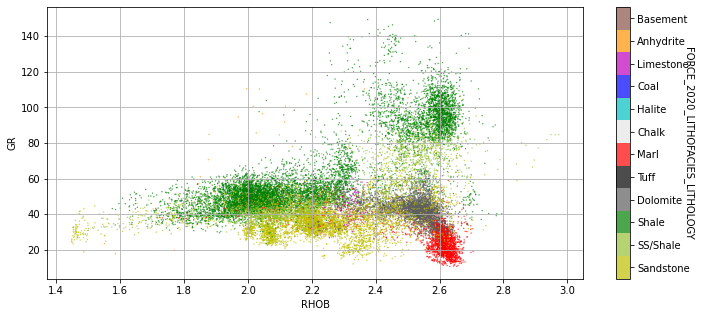

In [56]:
iwell = 0
welldata = validdata[validdata['WELL'] == validnwellcodes1[validwellnames[iwell]]]

las = lasio.LASFile()
numerical_columns = validdata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    logvalues = welldata[log].values.astype('float')
    logvalues[logvalues==-9999.] = np.nan
    las.add_curve(log, logvalues)
las.write('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'), version=1.2)

logs = Logs('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'))

fig, ax, scatax, cbar = \
    logs.visualize_crossplot('RHOB', 'GR', 
                             curvecolor='FORCE_2020_LITHOFACIES_LITHOLOGY', 
                             thresh2=150,
                             cmap=lithofacies_colors.values(),                                     
                             cbar=True, clims=[0,nlithofacies-1],
                             cbarlabels=list(lithofacies_names.values()), 
                             figsize=(12,5));

Let's now drop the two added columns to the validdata dataframe to be able to use it again with another model

In [57]:
validdata = validdata.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY',
                            'FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'], axis=1)

### Deep Feedforward neural network

Let's start by removing so of the rows from our data so that we have less unbalanced lithofacies. We will see that this makes a difference. Especially with Neural Networks it is important to avoid very unbalanced classes.

In [58]:
traindata_balanced, trainlitho_balanced = traindata.copy(), trainlitho.copy()
    
for ifacies in [2, 0, 1, 5, 3, 9, 6, 7]:
    traindata_balanced.reset_index(drop=True, inplace=True)
    trainlitho_balanced.reset_index(drop=True, inplace=True)

    trainlitho_facies = np.where(trainlitho_balanced == ifacies)[0]
    ifacies_drop = np.random.permutation(trainlitho_facies)[5000:]
    
    traindata_balanced = traindata_balanced.drop(index=ifacies_drop)
    trainlitho_balanced = trainlitho_balanced.drop(index=ifacies_drop)

In [59]:
print('Percentages of original lithofacies:')
trainlitho.value_counts() / trainlitho.shape[0] * 100

Percentages of original lithofacies:


2     61.621957
0     14.502349
1     13.044553
5      4.591593
3      2.675594
9      1.323159
6      0.841933
7      0.778167
10     0.349905
4      0.158229
8      0.102802
11     0.009759
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: float64

In [60]:
print('Percentages of rebalanced lithofacies:')
trainlitho_balanced.value_counts() / trainlitho_balanced.shape[0] * 100

Percentages of rebalanced lithofacies:


2     10.740908
0     10.740908
1     10.740908
5     10.740908
9     10.740908
3     10.740908
6     10.740908
7     10.740908
10     7.933235
4      3.587463
8      2.330777
11     0.221263
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: float64

We finally apply a standard resclare to our features and create PyTorch DataLoaders for both train and validation data

In [61]:
# Scaling pre-processing
scaler = StandardScaler()
scaler.fit(traindata)

# Define Train Set
X_train = torch.from_numpy(scaler.transform(traindata_balanced.values)).float()
y_train = torch.from_numpy(trainlitho_balanced.values).long()
train_dataset = TensorDataset(X_train, y_train)

# Define Valid Set
X_valid = torch.from_numpy(scaler.transform(validdata.values)).float()
y_valid = torch.from_numpy(validlitho.values).long()
valid_dataset = TensorDataset(X_valid, y_valid)

# Use Pytorch's functionality to load data in batches.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


Let's now create a simple Feed-forward network

In [62]:
set_seed(42)
network = nn.Sequential(nn.Linear(traindata.shape[1], 32, bias=True), 
                        nn.ReLU(),
                        nn.Linear(32, 64, bias=True), 
                        nn.ReLU(),
                        nn.Linear(64, 128, bias=True), 
                        nn.ReLU(),
                        nn.Linear(128, nlithofacies, bias=True))
network.apply(init_weights)

Sequential(
  (0): Linear(in_features=22, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=12, bias=True)
)

**In-class question**: How many trainable parameters are in this network?

**Exercise**: try to modify the network (both its width as well as the depth of the layers) and analyse how that affects the accuracy of both the training and validation sets. When do you start overfitting?

We are now ready to train our NN model. Most of this should look familar to you as it is done similar to the previous two notebooks. The main difference here is that we use the `CrossEntropyLoss` loss as we are dealing with a multi-label classification problem.

In [63]:
train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = \
    classification(network, train_loader, valid_loader, epochs=100, device=device)

Epoch 0, Training Loss 1.31, Training Accuracy 0.58, Validation Loss 1.40, Test Accuracy 0.52
Epoch 10, Training Loss 0.73, Training Accuracy 0.76, Validation Loss 1.15, Test Accuracy 0.62
Epoch 20, Training Loss 0.70, Training Accuracy 0.77, Validation Loss 1.18, Test Accuracy 0.63
Epoch 30, Training Loss 0.69, Training Accuracy 0.78, Validation Loss 1.15, Test Accuracy 0.63
Epoch 40, Training Loss 0.69, Training Accuracy 0.78, Validation Loss 1.24, Test Accuracy 0.63
Epoch 50, Training Loss 0.69, Training Accuracy 0.78, Validation Loss 1.12, Test Accuracy 0.64
Epoch 60, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.15, Test Accuracy 0.63
Epoch 70, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.21, Test Accuracy 0.61
Epoch 80, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.17, Test Accuracy 0.61
Epoch 90, Training Loss 0.68, Training Accuracy 0.78, Validation Loss 1.16, Test Accuracy 0.64


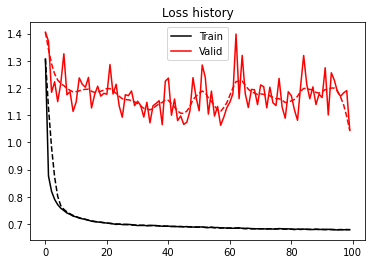

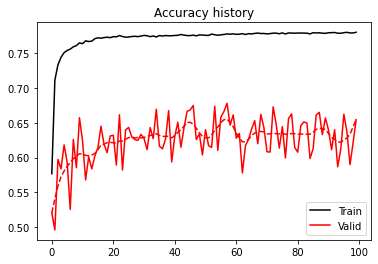

In [64]:
plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(filtfilt(np.ones(5)/5, 1, train_loss_history), '--k')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.plot(filtfilt(np.ones(5)/5, 1, valid_loss_history), '--r')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.plot(filtfilt(np.ones(5)/5, 1, valid_acc_history), '--r')
plt.title('Accuracy history')
plt.legend();

We obtain a decent accuracy for both training and validation. The curves (both loss and accuracy) are however quite noisy, sign that the network is definitely struggling to explain our data. This is not surprising as none of the best models submitted in the FORCE competitions used a Neural Network. It is important to remember that ML is not just about DNN and that other algorithms may be more useful in some specific scenarios. 

**Exercise**: try to use a larger training data with unbalanced classes and look into how you can weight classes based on the amount of expected occurrencies in the `CrossEntropyLoss()`. Hint: look at the `weight` parameter.

Finally, we use the trained model to make predictions for the entire training and validation data.

In [65]:
network.eval()
network.to(device)
with torch.no_grad():    
    y_train_pred = nn.Softmax(dim=1)(network(X_train.to(device)))
    y_valid_pred = nn.Softmax(dim=1)(network(X_valid.to(device)))
print("Train set accuracy: ", accuracy_score(y_train, np.argmax(y_train_pred.detach().cpu().numpy(), axis=1)))
print("Test set accuracy: ", accuracy_score(y_valid, np.argmax(y_valid_pred.detach().cpu().numpy(), axis=1)))

Train set accuracy:  0.7801336168932999
Test set accuracy:  0.6544029474635478


In [66]:
train_nnpred = np.argmax(y_train_pred.detach().cpu().numpy(), axis=1)
valid_nnpred = np.argmax(y_valid_pred.detach().cpu().numpy(), axis=1)

In [67]:
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY']= validlitho
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_PRED'] = valid_pred
validdata['FORCE_2020_LITHOFACIES_LITHOLOGY_NNPRED'] = valid_nnpred

Let's look again at some metrics to evaluate the quality of our model

In [68]:
show_evaluation(train_nnpred, trainlitho_balanced)

Force score is: -0.6018130652402741
Accuracy is: 0.7801336168932999
F1 is: 0.7872635733599236


In [69]:
show_evaluation(valid_nnpred, validlitho)

Force score is: -0.8627522114666064
Accuracy is: 0.6544029474635478
F1 is: 0.6275751368555039


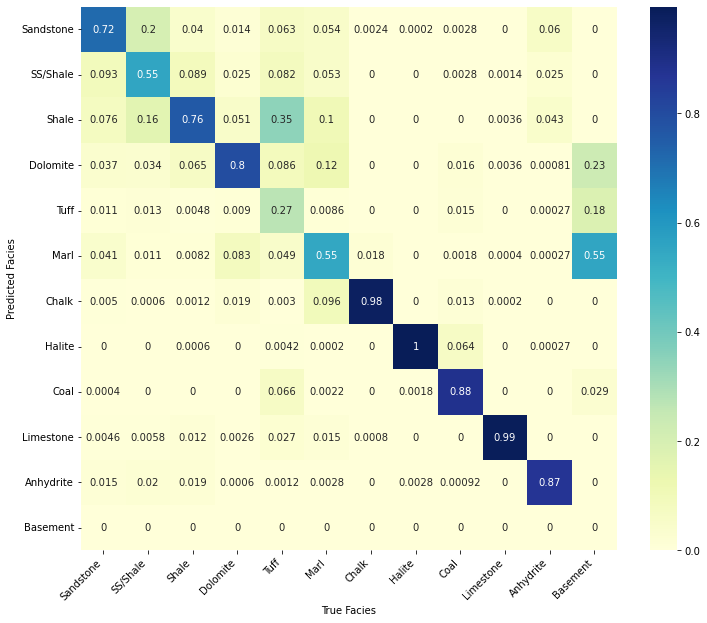

In [70]:
confusion_matrix_facies(train_nnpred, trainlitho_balanced.values, 
                        facies_labels=list(lithofacies_names.values()));

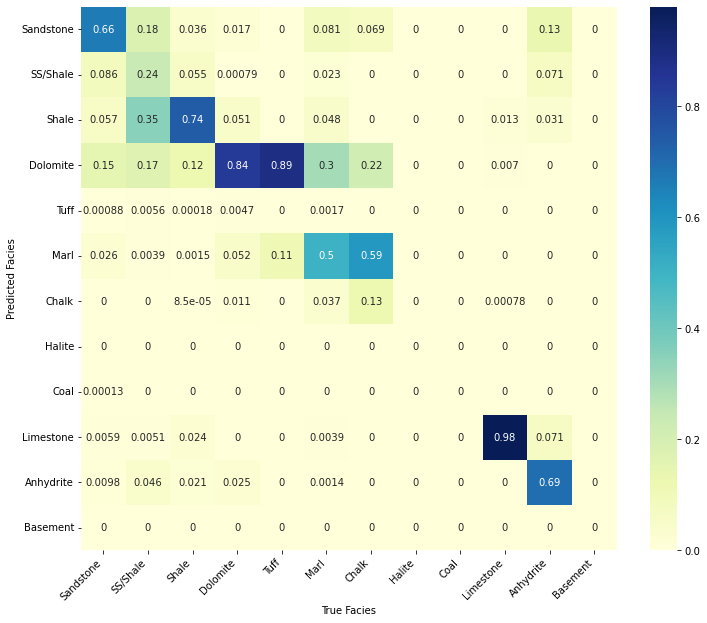

In [71]:
confusion_matrix_facies(valid_nnpred, validlitho.values, 
                        facies_labels=list(lithofacies_names.values()));

Finally we visulize the MAP estimation for both models alongside the true labels for the different wells in the validation set.

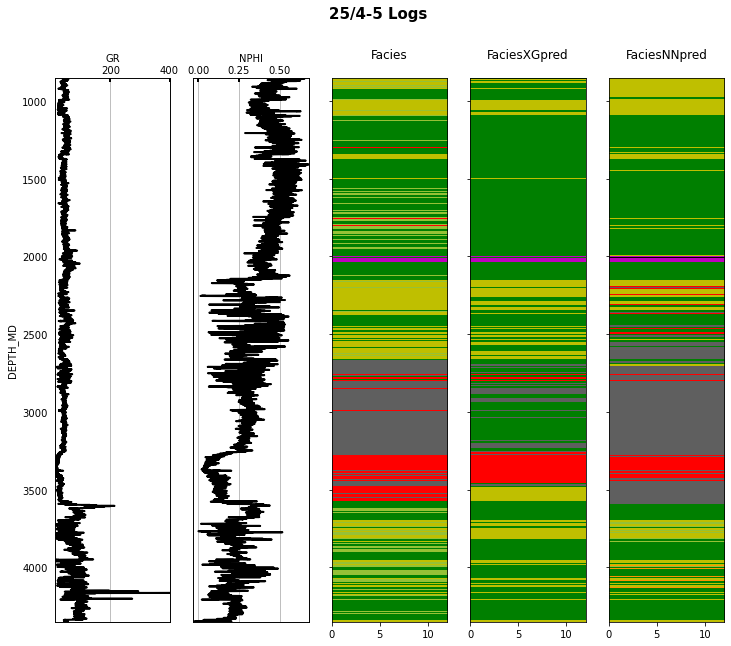

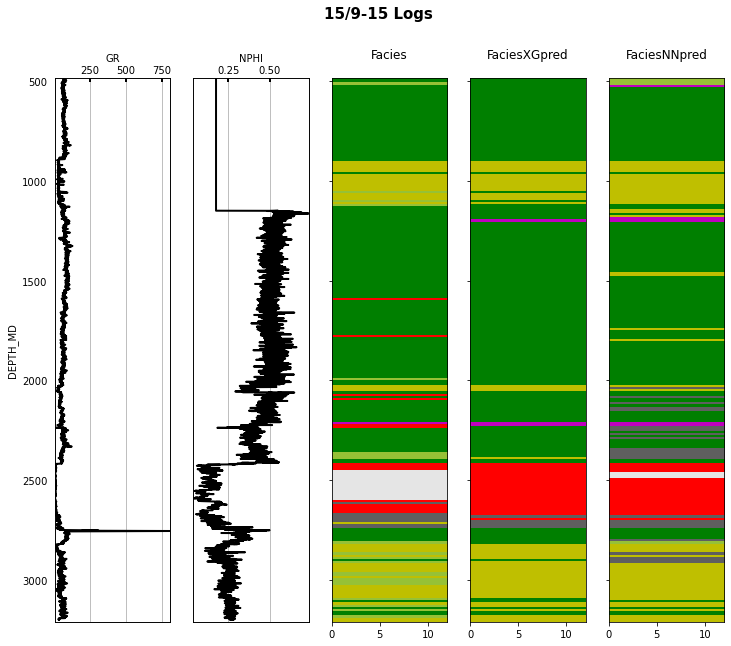

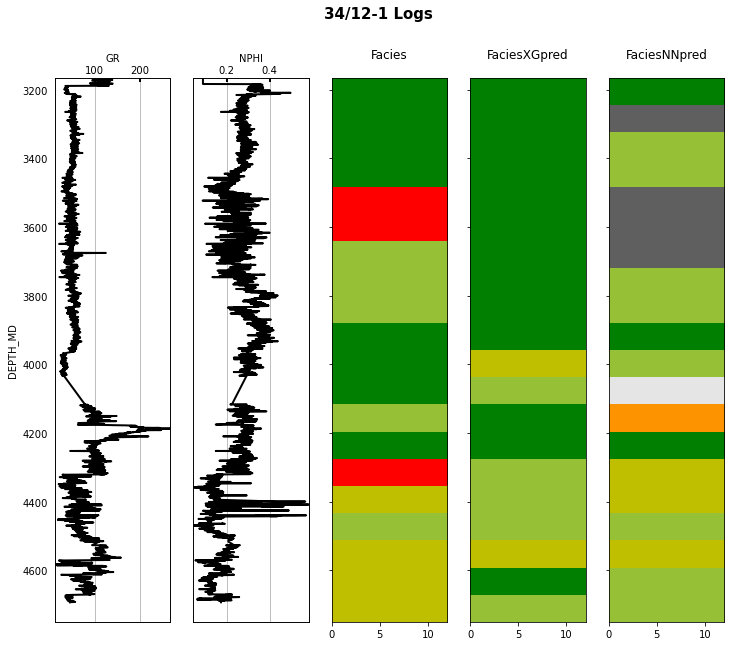

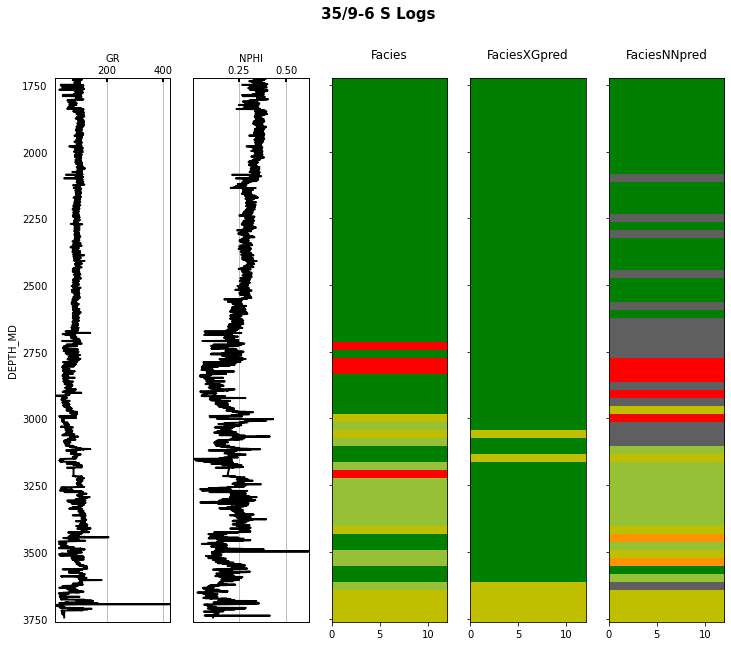

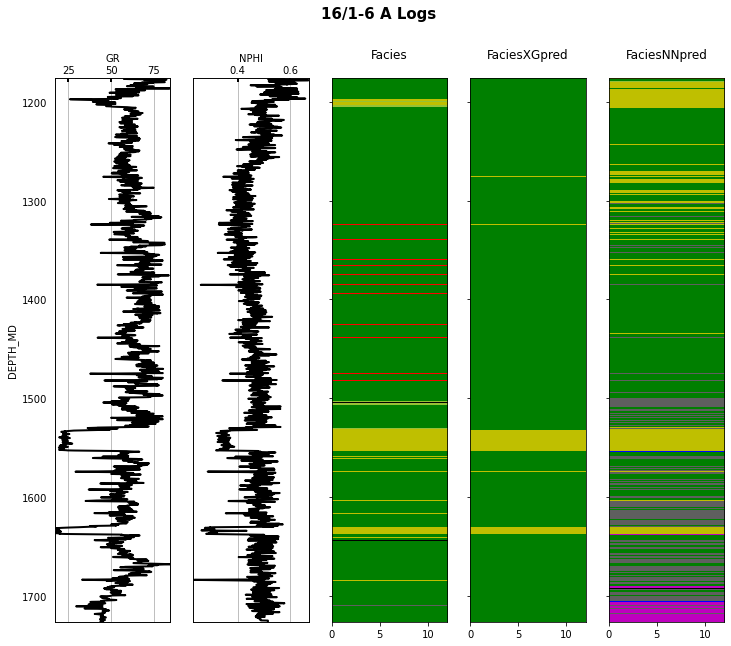

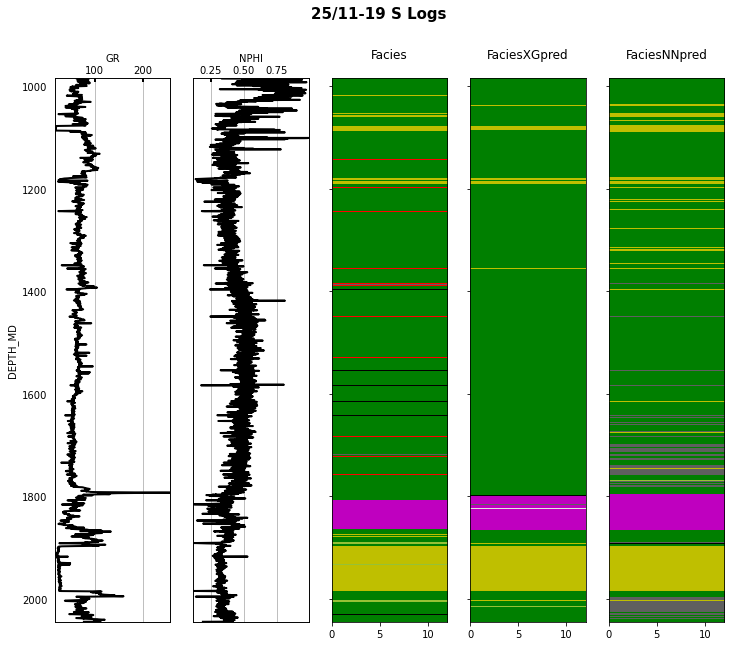

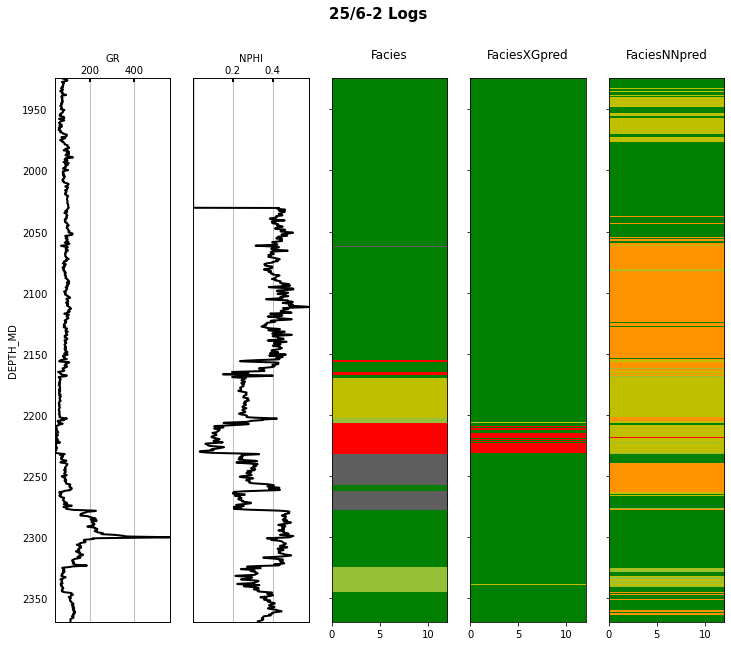

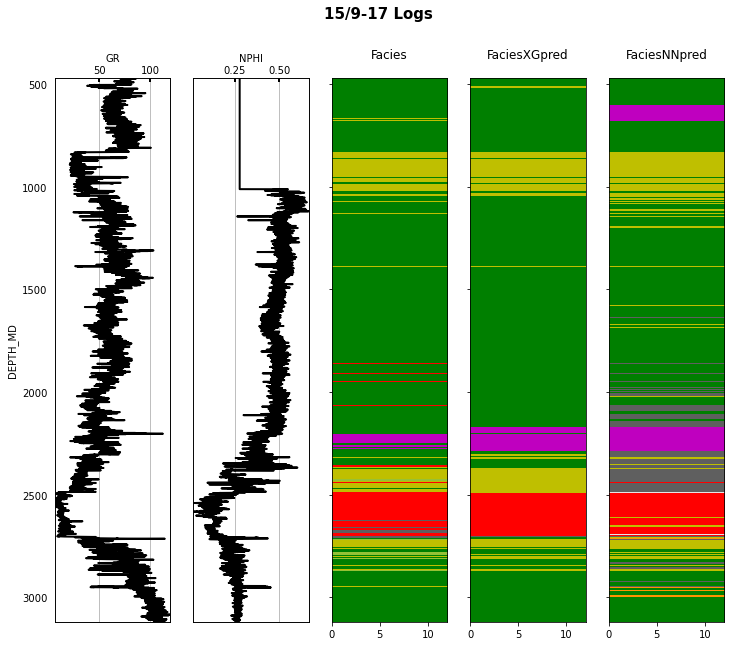

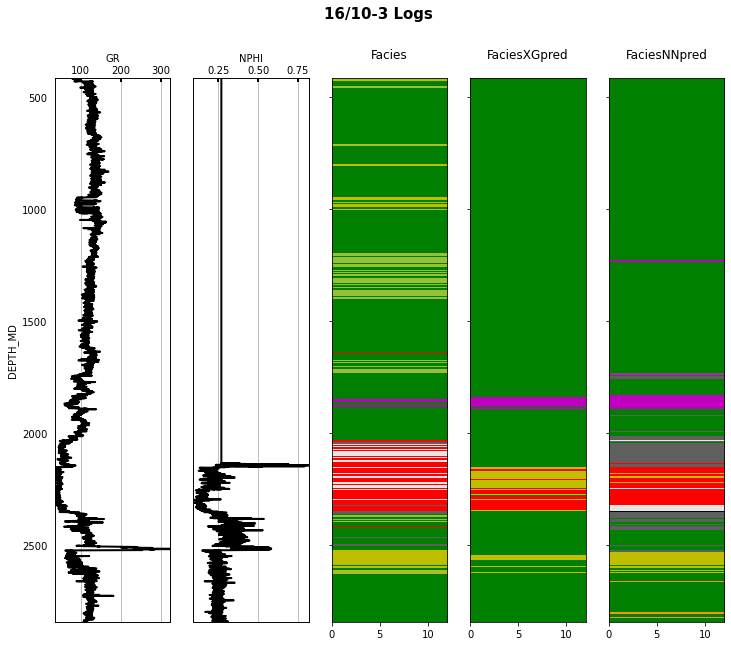

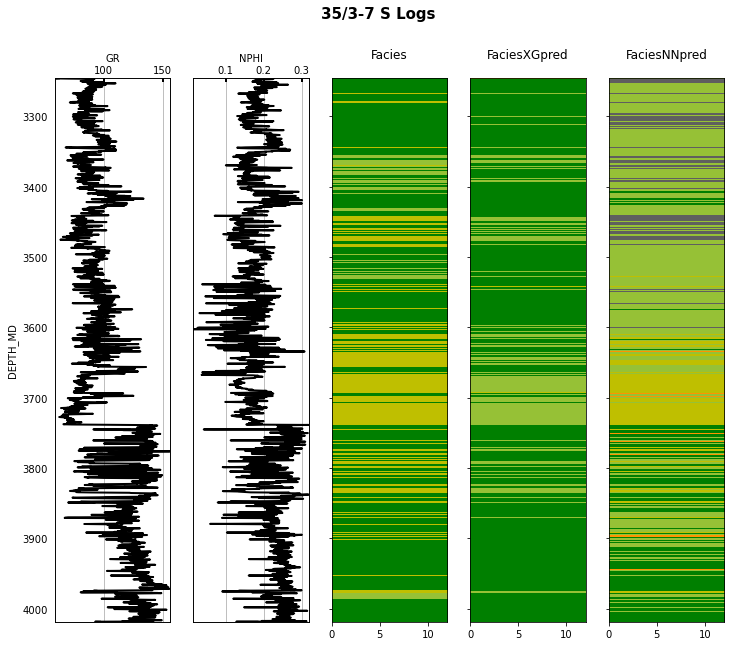

In [72]:
for iwell in range(validnwells):
    welldata = validdata[validdata['WELL'] == validnwellcodes1[validwellnames[iwell]]]

    las = lasio.LASFile()
    numerical_columns = validdata.select_dtypes(include=np.number).columns
    for log in numerical_columns:
        las.add_curve(log, welldata[log].values)
    las.write('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'), version=1.2)

    logs = Logs('../../data/welllogs/%s_predicted.las' %  validwellnames[iwell].replace('/', '_'))
    fig, axs = logs.visualize_logcurves(dict(GR=dict(logs=['GR'],
                                             colors=['k'],
                                             xlim=(np.nanmin(logs.logs['GR']),
                                                   np.nanmax(logs.logs['GR']))),
                                             NPHI=dict(logs=['NPHI'],
                                                       colors=['k'],
                                                       xlim=(np.nanmin(logs.logs['NPHI']),
                                                             np.nanmax(logs.logs['NPHI']))),
                                             Facies=dict(log='FORCE_2020_LITHOFACIES_LITHOLOGY', 
                                                         colors=lithofacies_colors.values(), 
                                                         names=lithofacies_names.values()),
                                             FaciesXGpred=dict(log='FORCE_2020_LITHOFACIES_LITHOLOGY_PRED', 
                                                             colors=lithofacies_colors.values(), 
                                                             names=lithofacies_names.values()),
                                             FaciesNNpred=dict(log='FORCE_2020_LITHOFACIES_LITHOLOGY_NNPRED', 
                                                               colors=lithofacies_colors.values(), 
                                                               names=lithofacies_names.values())),
                             depth='DEPTH_MD', figsize=(12, 10))
    fig.suptitle('%s Logs' % validwellnames[iwell], fontsize=15, fontweight='bold', y=.98);

That's it! You have learned how to apply 2 ML algorithms to the problem of multi-label classification, and more specifically within the context of lithofacies prediction from well logs. 

We have seen how to do so using a Feed-forward Neural Network. However, we have noticed how in this context a vanilla Feed-forward Neural Network can be easily beaten by other algorithms such as XGBoost. This is not surprising as similar conclusions have been reached for other datasets on this very same classification task.

We will come back to this problem in a couple of weeks after we have learned about *Sequence modelling*, i.e., Neural Networks that can take into account the correlation between different depth levels in our well logs and use this to make more accurate predictions.

Moreover, if you are interested to see how state-of-the-art Transformer models perform on this dataset, take a look at one of the [projects](https://github.com/hatsyim/wireline_attention.) of the 2022 class. 

In the meantime, if you are interest to know more about the sub-optimal performance of neural networks with tabular-like data, have a look at the following references:

- [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889)
- [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253)